## Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import tensorflow as tf
from tabulate import tabulate

## Download dữ liệu phân bón từ google drive về

In [2]:
!gdown --id 1Ca3JUKq-r9J_1KhUlpXleQhH2C2m6jWw
!gdown --id 1zjHTaRmrTsRg51e6_sN75uvvYlLlrXED

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ca3JUKq-r9J_1KhUlpXleQhH2C2m6jWw
To: /content/chemical_analysis.xlsx
100% 56.2k/56.2k [00:00<00:00, 126MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zjHTaRmrTsRg51e6_sN75uvvYlLlrXED
To: /content/spectra.xlsx
100% 4.38M/4.38M [00:00<00:00, 150MB/s]


In [3]:
chemical_df = pd.read_excel('/content/chemical_analysis.xlsx')
spectral_df = pd.read_excel('/content/spectra.xlsx')

## Tổng hợp thông tin giữa 2 bảng

In [4]:
spectra_data = spectral_df.iloc[:, 1:]
classes = chemical_df['Manure_type']
data = pd.concat([classes, spectra_data], axis=1)
spectra_data = data.iloc[:, 1:]

## Preprocessing

### Mã hóa Label

In [5]:
Class = data[['Manure_type']].values
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(Class)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
label_encoder.inverse_transform([0,1,2,3,4,5])

array(['Cattle manure', 'Compost', 'Other', 'Pig manure',
       'Poultry droppings', 'Poultry manure'], dtype=object)

In [7]:
print("Số mẫu: ",spectra_data.shape[0])
print("Số chiều vector phổ NIR: ",spectra_data.shape[1])

Số mẫu:  490
Số chiều vector phổ NIR:  1003


### Làm mượt dữ liệu bằng Savitzky-Golay filter, loại bỏ dấu phẩy bởi dấu chấm

In [8]:
spectra_data_cleaned = spectra_data.copy()
spectra_data_cleaned.iloc[:, 1:] = spectra_data_cleaned.iloc[:, 1:].apply(lambda x: x.str.replace(',', '.', regex=True))
spectra_data_cleaned = spectra_data_cleaned.iloc[:, 1:].astype('float64')
spectra_data_smoothed = spectra_data_cleaned.apply(lambda x: savgol_filter(x, 21, 3), axis=0)

In [9]:
spectra_data.shape

(490, 1003)

### Chuẩn hóa dữ liệu bằng SNV

In [10]:
scaler = StandardScaler()
Spectra_data = scaler.fit_transform(spectra_data_smoothed)

### Split dữ liệu thành Train và Test

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)

## Mô hình SVM

In [12]:
from sklearn import svm
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

model = svm.SVC(kernel='linear')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác:", accuracy)
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

Độ chính xác: 0.9455782312925171
F1_Score:  0.7190853645460086
Precision:  0.6916989664082687
Recall:  0.7530684754521962


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
X_train.shape

(343, 1002)

## Mô Hình MLP

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')
encoded_classes = encoder.fit_transform(encoded_classes.reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)
print(X_train.shape , y_train.shape)

(343, 1002) (343, 6)


In [15]:
def MLP():
  model = Sequential([
    layers.Dense(512, activation='relu', input_dim=1002),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(6 , activation='softmax')
  ])
  return model

model = MLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = CategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/500
11/11 [==============================] - 6s 26ms/step - loss: 1.0672 - accuracy: 0.7347 - val_loss: 0.7438 - val_accuracy: 0.8639
Epoch 2/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6860 - accuracy: 0.8630 - val_loss: 0.5602 - val_accuracy: 0.8844
Epoch 3/500
11/11 [==============================] - 0s 8ms/step - loss: 0.6044 - accuracy: 0.8746 - val_loss: 0.4890 - val_accuracy: 0.8844
Epoch 4/500
11/11 [==============================] - 0s 7ms/step - loss: 0.5508 - accuracy: 0.8746 - val_loss: 0.4200 - val_accuracy: 0.9048
Epoch 5/500
11/11 [==============================] - 0s 7ms/step - loss: 0.5010 - accuracy: 0.8834 - val_loss: 0.3984 - val_accuracy: 0.9116
Epoch 6/500
11/11 [==============================] - 0s 8ms/step - loss: 0.4678 - accuracy: 0.8805 - val_loss: 0.3917 - val_accuracy: 0.8980
Epoch 7/500
11/11 [==============================] - 0s 8ms/step - loss: 0.4410 - accuracy: 0.8746 - val_loss: 0.3577 - val_accuracy: 0.9048
Epoch 8/500


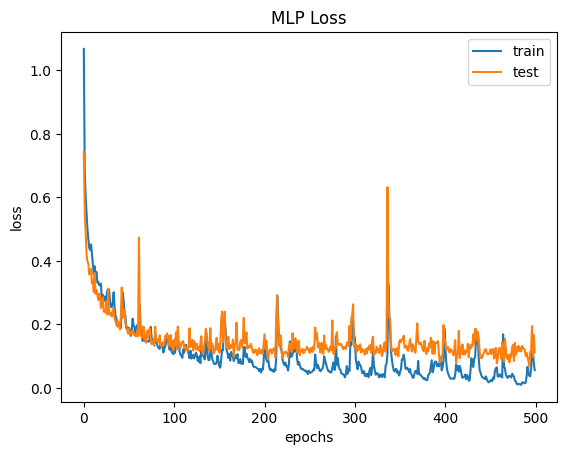

<Figure size 800x1300 with 0 Axes>

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('MLP Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

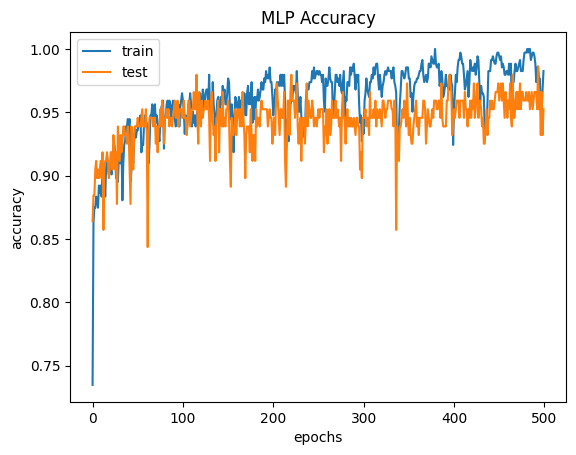

<Figure size 800x1300 with 0 Axes>

In [17]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('MLP Accuracy')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.9523809523809523
F1_Score:  0.8511883541295305
Precision:  0.8352690669763841
Recall:  0.8785097755362535


In [19]:
model.save_weights('MLP.h5')

## Mô hình CNN

In [20]:
def convert_to_pseudo_image(Spectra_data):
  Spectra_data = tf.convert_to_tensor(Spectra_data)
  Spectra_data= tf.expand_dims(Spectra_data,axis=2)
  Spectra_data = tf.expand_dims(Spectra_data,axis=3)
  Spectra_data = tf.reshape(Spectra_data[:,0:968],(Spectra_data.shape[0],22,22,2))
  return Spectra_data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)

In [22]:
X_train = convert_to_pseudo_image(X_train)
X_test = convert_to_pseudo_image(X_test)

In [23]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (343, 22, 22, 2)
X_test shape: (147, 22, 22, 2)
y_train shape: (343, 6)
y_test shape: (147, 6)


In [24]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def CNN():
  inputs = Input(shape=(22, 22, 2))
  x = layers.Conv2D(kernel_size=3, filters=16, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(kernel_size=3, filters=32, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(kernel_size=3, filters=64, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(6, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  return model

model = CNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = CategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/500
11/11 [==============================] - 7s 54ms/step - loss: 1.5492 - accuracy: 0.4431 - val_loss: 1.7469 - val_accuracy: 0.0748
Epoch 2/500
11/11 [==============================] - 0s 13ms/step - loss: 1.1820 - accuracy: 0.8017 - val_loss: 1.7120 - val_accuracy: 0.7211
Epoch 3/500
11/11 [==============================] - 0s 12ms/step - loss: 0.9872 - accuracy: 0.8251 - val_loss: 1.6689 - val_accuracy: 0.8367
Epoch 4/500
11/11 [==============================] - 0s 12ms/step - loss: 0.8655 - accuracy: 0.8163 - val_loss: 1.6192 - val_accuracy: 0.8435
Epoch 5/500
11/11 [==============================] - 0s 12ms/step - loss: 0.7895 - accuracy: 0.8251 - val_loss: 1.5633 - val_accuracy: 0.8503
Epoch 6/500
11/11 [==============================] - 0s 12ms/step - loss: 0.7467 - accuracy: 0.8280 - val_loss: 1.4984 - val_accuracy: 0.8503
Epoch 7/500
11/11 [==============================] - 0s 13ms/step - loss: 0.6844 - accuracy: 0.8280 - val_loss: 1.4328 - val_accuracy: 0.8435
Epoch 

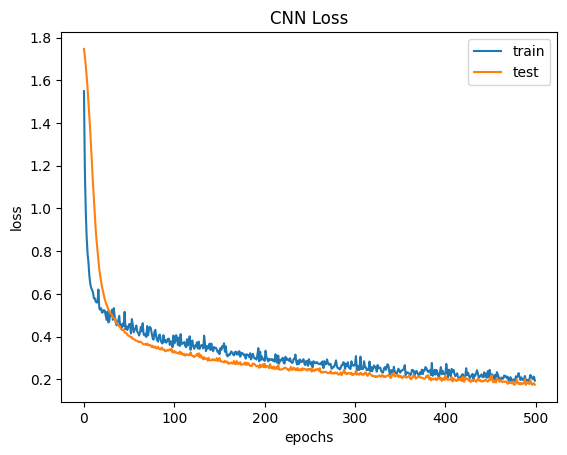

<Figure size 800x1300 with 0 Axes>

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('CNN Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

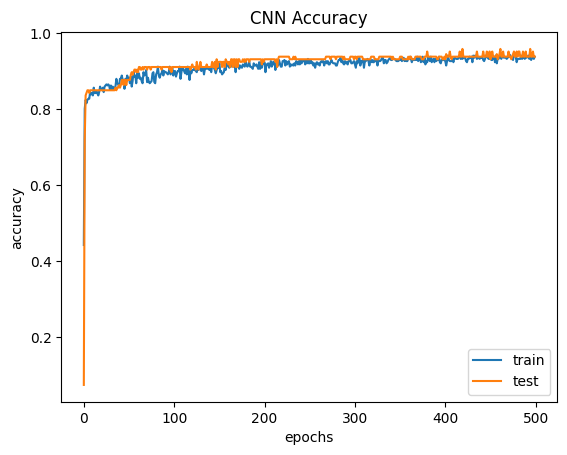

<Figure size 800x1300 with 0 Axes>

In [26]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('CNN Accuracy')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)


print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.9387755102040817
F1_Score:  0.6358674463937622
Precision:  0.6430125725338491
Recall:  0.6333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
model.save_weights('CNN.h5')

## ResNet

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)
X_train = convert_to_pseudo_image(X_train)
X_test = convert_to_pseudo_image(X_test)

In [30]:
def residual_block(x, filters):

  x1 = layers.Conv2D(kernel_size=1, filters=filters, padding="same")(x)
  x1 = layers.BatchNormalization()(x1)

  x2 = layers.Conv2D(kernel_size=3, filters=filters, padding="same")(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)
  x2 = layers.Conv2D(kernel_size=3, filters=filters, padding="same")(x2)
  x2 = layers.BatchNormalization()(x2)

  out = layers.Concatenate()([x1, x2])
  out = layers.ReLU()(out)

  return out

def ResNet():

  inputs = Input(shape=(22, 22, 2))
  x = residual_block(inputs,16)
  x = residual_block(x,32)
  x = residual_block(x,64)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(6, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  return model

In [31]:
model = ResNet()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = CategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/500
11/11 [==============================] - 7s 124ms/step - loss: 1.5013 - accuracy: 0.3848 - val_loss: 1.6944 - val_accuracy: 0.8367
Epoch 2/500
11/11 [==============================] - 0s 19ms/step - loss: 0.9768 - accuracy: 0.8309 - val_loss: 1.6259 - val_accuracy: 0.8027
Epoch 3/500
11/11 [==============================] - 0s 23ms/step - loss: 0.7948 - accuracy: 0.8251 - val_loss: 1.5394 - val_accuracy: 0.7959
Epoch 4/500
11/11 [==============================] - 0s 19ms/step - loss: 0.6888 - accuracy: 0.8397 - val_loss: 1.4399 - val_accuracy: 0.7959
Epoch 5/500
11/11 [==============================] - 0s 14ms/step - loss: 0.6470 - accuracy: 0.8367 - val_loss: 1.3426 - val_accuracy: 0.7891
Epoch 6/500
11/11 [==============================] - 0s 18ms/step - loss: 0.6081 - accuracy: 0.8426 - val_loss: 1.2474 - val_accuracy: 0.7959
Epoch 7/500
11/11 [==============================] - 0s 14ms/step - loss: 0.5762 - accuracy: 0.8426 - val_loss: 1.1619 - val_accuracy: 0.8027
Epoch

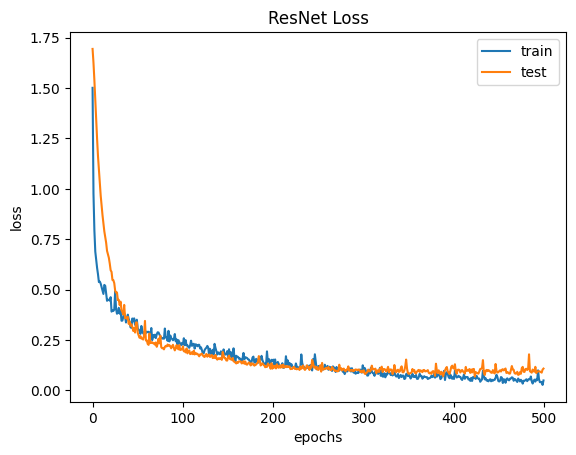

<Figure size 800x1300 with 0 Axes>

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ResNet Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

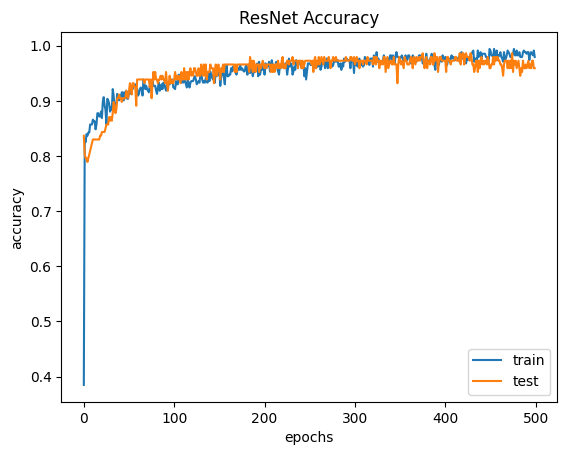

<Figure size 800x1300 with 0 Axes>

In [33]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('ResNet Accuracy')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

5/5 [==============================] - 0s 5ms/step
Accuracy: 0.9591836734693877
F1_Score:  0.829858464888405
Precision:  0.8996031746031745
Recall:  0.8182061579651941


In [35]:
model.save_weights('Resnet.h5')